## Training a Fully Convolutional Network for Brain Tumor Segmentation

### In this notebook we will train a fully convolutional network to perform segmentation on the BRATS dataset. We will use Tensorflow to construct the network and optimize its weights.

In [31]:
import SimpleITK as sitk
import os
import h5py
import numpy as np
import matplotlib
import os

import tensorflow as tf
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24})
import matplotlib.pyplot as plt

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [32]:
data_path = 'C:/Users/user/Desktop/Brain-Tumor-Segmentation-BRATS2015-master/Brain-Tumor-Segmentation-BRATS2015-master/version2/'

### Get the processed data

#### Here we get the processed data using H5Py. H5Py allows us to access the data like we would with a numpy array.

In [33]:
data = h5py.File(data_path+'brats_train.h5','r')
data_test = h5py.File(data_path+'brats_test.h5','r')


X_p_train = data['X_positive']
Y_p_train = data['Y_positive']
X_n_train = data['X_negative']
Y_n_train = data['Y_negative']
print (np.amax(Y_p_train))
print ("X_p_train shape = {}\n Y_p_train shape = {}\n X_n_train shape = {}\n Y_n_train shape = {}".
format(X_p_train.shape, Y_p_train.shape, X_n_train.shape, Y_n_train.shape))

X_p_test = data_test['X_positive']
Y_p_test = data_test['Y_positive']
X_n_test = data_test['X_negative']
Y_n_test = data_test['Y_negative']

print ("X_p_test shape = {}\n Y_p_test shape = {}\n X_n_test shape = {}\n Y_n_test shape = {}".
format(X_p_test.shape, Y_p_test.shape, X_n_test.shape, Y_n_test.shape))

4.0
X_p_train shape = (15753, 128, 128)
 Y_p_train shape = (15753, 128, 128)
 X_n_train shape = (21292, 128, 128)
 Y_n_train shape = (21292, 128, 128)
X_p_test shape = (1406, 128, 128)
 Y_p_test shape = (1406, 128, 128)
 X_n_test shape = (1694, 128, 128)
 Y_n_test shape = (1694, 128, 128)


### Tensorflow functions

#### In this section we define some convenience functions to build our neural network.

#### For this example we will train a convolutional network and use the leaky relu activation function. To make it easier to build our network we define a function that constructs a convolution layer `conv2D` and a function that applies many convolutional layers in sequence `conv_block`

#### For training we need to sample batches of data from our dataset, so we also define a function `get_batch` which randomly selects positive and negative examples from our datasets.

In [34]:
def leaky_relu(x):
    return tf.maximum(0.2*x,x)

def conv2D(x, dims=[3, 3], filters=32, strides=[1, 1],
           std=1e-3, padding='SAME', activation=tf.identity, scope='conv2d'):
  """
  args:
      x, (tf tensor), tensor with shape (batch,width,height,channels)
      dims, (list), size of convolution filters
      filters, (int), number of filters used
      strides, (list), number of steps convolutions slide
      std, (float/string), std of weight initialization, 'xavier' for xavier
          initialization
      padding, (string), 'SAME' or 'VALID' determines if input should be padded
          to keep output dimensions the same or not
      activation, (tf function), tensorflow activation function, e.g. tf.nn.relu
      scope, (string), scope under which to store variables
  returns:
      a, (tf tensor), the output of the convolution layer, has size
          (batch, new_width , new_height , filters)
  """
  with tf.variable_scope(scope):
    s = x.get_shape().as_list()

    shape = dims + [s[3], filters]

    if std == 'xavier':
      std = np.sqrt(2.0 / (s[1] * s[2] * s[3]))

    W = tf.Variable(tf.random_normal(shape=shape, stddev=std), name='W')

    b = tf.Variable(tf.ones([filters]) * std, name='b')

    o = tf.nn.convolution(x, W, padding, strides=strides)

    o = o + b

    a = activation(o)

    return a

def conv_block(x,dims=[5,5],filters=16,num_layers=5,activation=tf.identity,scope='conv_block'):
    o = x
    with tf.variable_scope(scope):
        for i in range(1,num_layers):
            scope = 'conv_{}'.format(i)
            o = conv2D(o,dims=dims,filters=filters,std=std,activation=act, scope=scope)
    return o

def get_batch(Xp,Yp, Xn, Yn, n=32):
    Np = Xp.shape[0]
    Nn = Xn.shape[0]
    
    inds_p = sorted(np.random.choice(range(Np),size=n, replace=False))
    inds_n = sorted(np.random.choice(range(Nn),size=n, replace=False))
    
    xp = Xp[inds_p,:,:]
    yp = Yp[inds_p,:,:]
    
    xn = Xn[inds_n]
    yn = Yn[inds_n]
    
    x = np.concatenate((xp,xn))
    y = np.concatenate((yp,yn))
    
    x = x[:,:,:,np.newaxis].astype(np.float32)
    return x,y

### Network parameters

#### Specifying network parameters is where a lot of the black magic of Deep Learning happens. For this example we keep things simple by using 5 layers, with each layer having filter dimensions of 7 x 7. For training we try 10,000 iterations with a learning rate of 1e-3. A lot of these parameters are determined by trying out different values and seeing what works.

#### Since each labeled image has few labeled pixels, we will use weights in our loss function to increase their importance. The more infrequent labels receive higher weights.

In [35]:
#train_steps = 10000
train_steps = 10000
Nbatch = 16
#print_step = 200
print_step = 10

W = X_p_train.shape[1]
H = W
C = 1

num_layers = 5
filters = 32
dims = [7,7]
strides = [1,1]

act = leaky_relu

std=1e-2
num_classes=5
learning_rate=1e-3

class_weights= np.asarray([1.0, 60.0, 20.0, 80.0, 80.0])
# class_weights = class_weights/np.sum(class_weights)


In [36]:
%%latex

Here we construct the tensorflow graph for our neural network.

The first step is to construct placeholder variables for the input. The images need a placeholder variable
with size $W x H x C$, and the segmentations need a placeholder with dimensions $W x H$.

Ater that we apply a series of convolutional layers with the specified amount of filters, followed by a final
convolutional layer with the same number of filters as the number of output classes for each pixel.

For the loss function we use a weighted cross entropy loss function
$L = \sum_{i}\beta_i \sum_{jk}-y_{jki}\log(\hat{y}_{jki})$ where $\beta_i$ is the weight for each class

The weights help the network learn to indentify labels which are rare.

<IPython.core.display.Latex object>

In [37]:
#Tensorflow graph construction

#construct input place holders
x = tf.placeholder(shape=[None,W,H,C],dtype=tf.float32)
y = tf.placeholder(shape=[None,W,H],dtype=tf.int32)

y_truth = tf.one_hot(y,depth=num_classes,axis=3)

#####################################
# Convolutional part
#####################################
o = conv_block(x,dims,filters,num_layers,act,scope="conv_block_1")

o = conv2D(o,dims=dims,filters=num_classes,strides=strides,std=std,
           activation=tf.identity, scope='conv_final')

yhat = tf.nn.softmax(o)

l_temp = tf.reduce_mean(-y_truth*tf.log(yhat+1e-5),axis=[0,1,2])

l_temp = l_temp*class_weights

loss = tf.reduce_mean(l_temp)

### Optimizer

#### Tensorflow provides optimizer objects we can use to optimizer our network. Here we use the AdamOptimizer and use it to minimize our loss function.

In [38]:
#Construct the optimizer and training operations
opt = tf.train.AdamOptimizer(learning_rate)
train = opt.minimize(loss)
init = tf.global_variables_initializer()

In [39]:
#Construct the tensorflow session and initialize the graph
sess = tf.Session()
sess.run(init)

### Training loop

#### In this section of the code we train the network and occasionally evalute its performance on the test set. In each training iteration a different batch of data is sampled.

In [40]:
#Start the train loop
train_hist = []
val_hist = []

for i in range(train_steps):
    xb,yb = get_batch(X_p_train,Y_p_train,X_p_train,Y_p_train,n=Nbatch)
    l,_=sess.run([loss,train],{x:xb,y:yb})

    if i%print_step == 0:
        xb,yb = get_batch(X_p_test,Y_p_test,X_n_test,Y_n_test,n=Nbatch)
        lval=sess.run(loss,{x:xb,y:yb})
        print ("iter: {} Train: {} Val: {}".format(i,l,lval))
        train_hist.append(l)
        val_hist.append(lval)

iter: 0 Train: 1.2647137641906738 Val: 0.9308439493179321
iter: 1 Train: 1.1589211225509644 Val: 0.9587615728378296
iter: 2 Train: 1.3610092401504517 Val: 0.9310051202774048
iter: 3 Train: 1.267035722732544 Val: 0.882114052772522
iter: 4 Train: 1.0838725566864014 Val: 1.0604442358016968
iter: 5 Train: 1.4499905109405518 Val: 0.9489585161209106
iter: 6 Train: 1.1253602504730225 Val: 0.798686146736145
iter: 7 Train: 1.0082682371139526 Val: 1.0888363122940063
iter: 8 Train: 0.9485498666763306 Val: 0.8546056747436523
iter: 9 Train: 1.3405343294143677 Val: 0.692723274230957
iter: 10 Train: 1.3125196695327759 Val: 1.0677504539489746
iter: 11 Train: 1.2852089405059814 Val: 0.7157855033874512
iter: 12 Train: 1.158156394958496 Val: 0.6928386092185974
iter: 13 Train: 0.8414303660392761 Val: 0.6410472989082336
iter: 14 Train: 1.0093412399291992 Val: 0.7581789493560791
iter: 15 Train: 1.1384327411651611 Val: 0.6075783967971802
iter: 16 Train: 0.843005359172821 Val: 0.5103570818901062
iter: 17 Trai

### Loss Curves

#### After training we can look at the loss curves to see whether our network is overfitting, underfitting or performing well. Due to training on batches the loss function is erratic, in this case it would be advisable to train for more iterations.

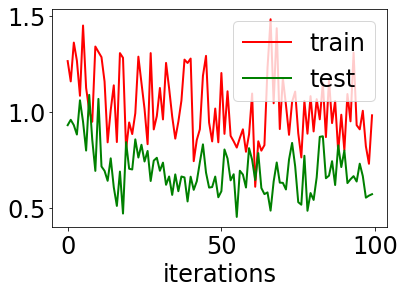

In [41]:
plt.figure()
plt.plot(train_hist,color='r',linewidth=2,label='train')
plt.plot(val_hist,color='g',linewidth=2,label='test')
plt.xlabel('iterations')
plt.legend()
plt.show()

### Neural Network Predictions

#### We can now evaluate the predicted segmentations our network makes by computing predictions on the test set and visualizing them. Our network does a reasonable job at identifying the general locations of the tumors and their severity which is not bad considering that we used a simple convolutional network. However, in some cases the network over segments or misses key parts of the tumor.

#### To get better performance we could experiment with different neural networks, e.g. trying more layers, more parameters, different activation functions, experimenting with pooling layers etc.

<Figure size 432x288 with 0 Axes>

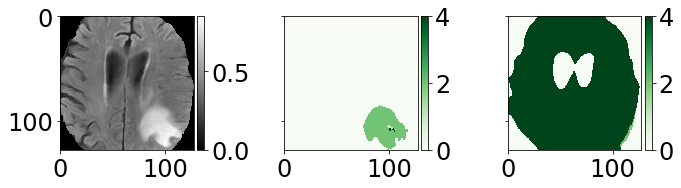

<Figure size 432x288 with 0 Axes>

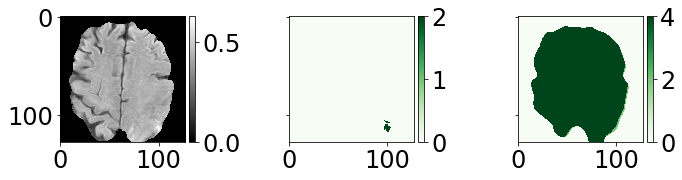

<Figure size 432x288 with 0 Axes>

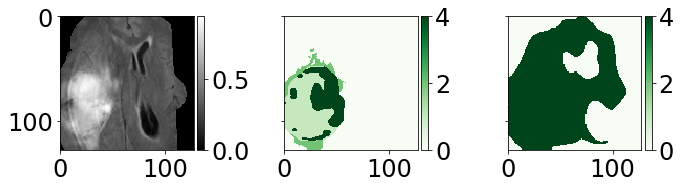

<Figure size 432x288 with 0 Axes>

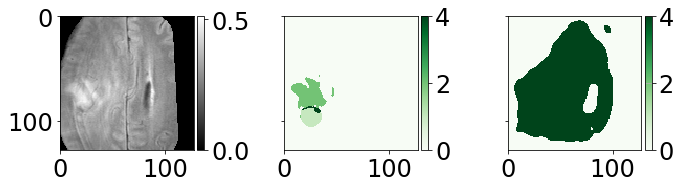

<Figure size 432x288 with 0 Axes>

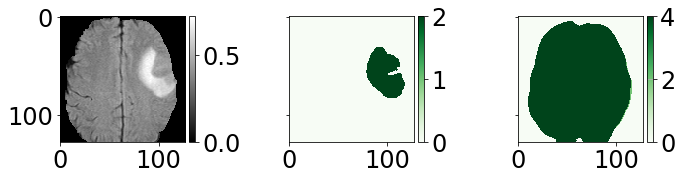

<Figure size 432x288 with 0 Axes>

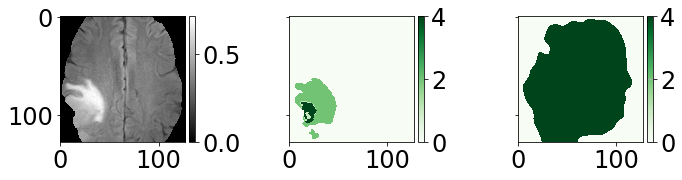

<Figure size 432x288 with 0 Axes>

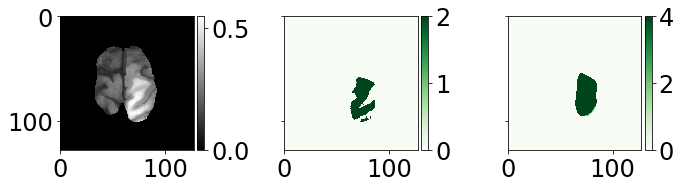

<Figure size 432x288 with 0 Axes>

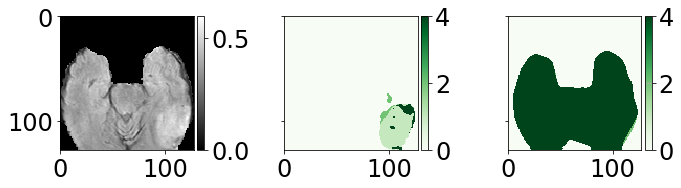

<Figure size 432x288 with 0 Axes>

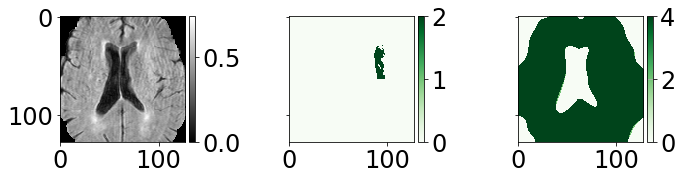

<Figure size 432x288 with 0 Axes>

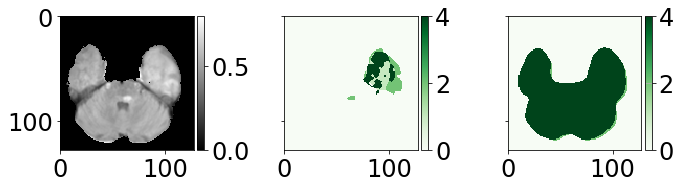

<Figure size 432x288 with 0 Axes>

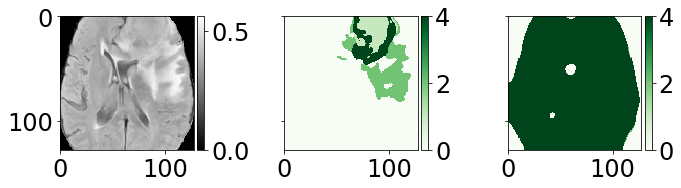

<Figure size 432x288 with 0 Axes>

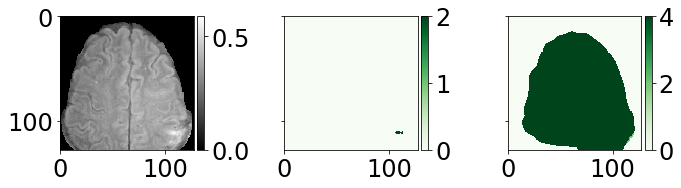

<Figure size 432x288 with 0 Axes>

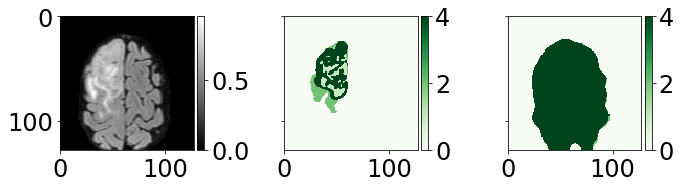

<Figure size 432x288 with 0 Axes>

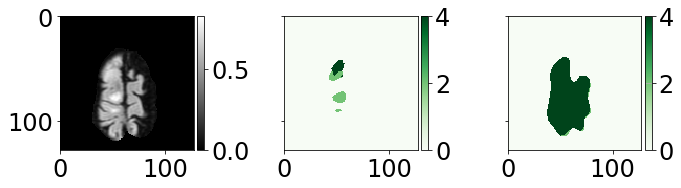

<Figure size 432x288 with 0 Axes>

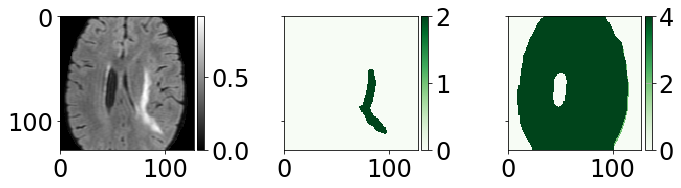

<Figure size 432x288 with 0 Axes>

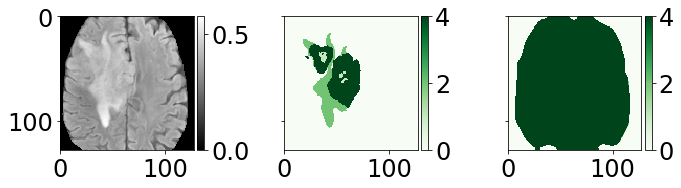

<Figure size 432x288 with 0 Axes>

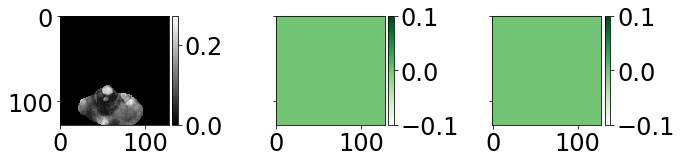

<Figure size 432x288 with 0 Axes>

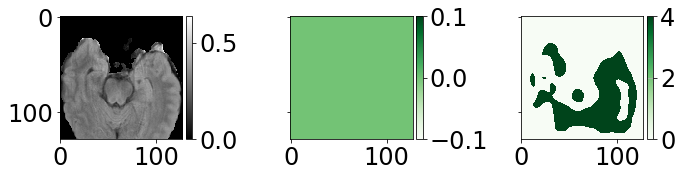

<Figure size 432x288 with 0 Axes>

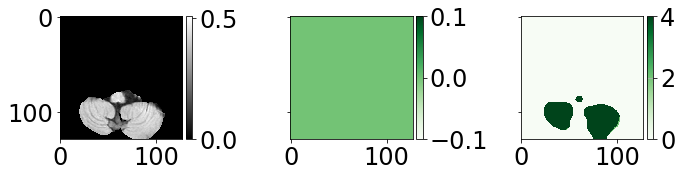

<Figure size 432x288 with 0 Axes>

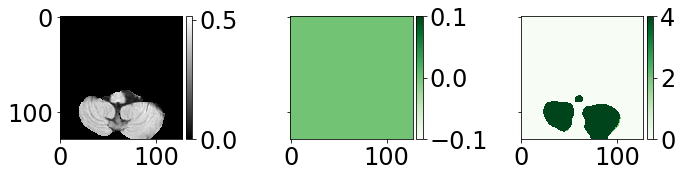

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def implot(mp,ax,cmap='gray'):
    im = ax.imshow(mp.astype(np.float32), cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)

    
xb,yb = get_batch(X_p_test,Y_p_test,X_n_test,Y_n_test,n=Nbatch)

yh = sess.run(yhat,{x:xb})

ypred = np.argmax(yh,axis=3)

#for i in range(32):
for i in range(20):

    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(10,3))
    #implot(xb[i,:,:,0],ax1)
    #implot(yb[i,:,:],ax2,cmap='spectral')
    #implot(ypred[i,:,:],ax3,cmap='spectral')
    
    implot(xb[i,:,:,0],ax1)
    implot(yb[i,:,:],ax2, cmap='Greens')
    implot(ypred[i,:,:],ax3, cmap='Greens')
    
    plt.grid('off')
    plt.tight_layout()
    plt.savefig('images_{}.pdf'.format(i),dpi=600)
    plt.show()